In [1]:
import gzip
import os
import re
import urllib
from concurrent.futures import ProcessPoolExecutor
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from tqdm import tqdm

In [2]:
dna_code = {
    "ATA": "I",
    "ATC": "I",
    "ATT": "I",
    "ATG": "M",
    "ACA": "T",
    "ACC": "T",
    "ACG": "T",
    "ACT": "T",
    "AAC": "N",
    "AAT": "N",
    "AAA": "K",
    "AAG": "K",
    "AGC": "S",
    "AGT": "S",
    "AGA": "R",
    "AGG": "R",
    "CTA": "L",
    "CTC": "L",
    "CTG": "L",
    "CTT": "L",
    "CCA": "P",
    "CCC": "P",
    "CCG": "P",
    "CCT": "P",
    "CAC": "H",
    "CAT": "H",
    "CAA": "Q",
    "CAG": "Q",
    "CGA": "R",
    "CGC": "R",
    "CGG": "R",
    "CGT": "R",
    "GTA": "V",
    "GTC": "V",
    "GTG": "V",
    "GTT": "V",
    "GCA": "A",
    "GCC": "A",
    "GCG": "A",
    "GCT": "A",
    "GAC": "D",
    "GAT": "D",
    "GAA": "E",
    "GAG": "E",
    "GGA": "G",
    "GGC": "G",
    "GGG": "G",
    "GGT": "G",
    "TCA": "S",
    "TCC": "S",
    "TCG": "S",
    "TCT": "S",
    "TTC": "F",
    "TTT": "F",
    "TTA": "L",
    "TTG": "L",
    "TAC": "Y",
    "TAT": "Y",
    "TAA": "*",
    "TAG": "*",
    "TGC": "C",
    "TGT": "C",
    "TGA": "*",
    "TGG": "W",
}
AA = set(dna_code.values())
idxes = [
    13,
    49,
    0,
    4,
    52,
    7,
    63,
    29,
    19,
    35,
    43,
    14,
    3,
    33,
    57,
    24,
    60,
    5,
    56,
    59,
    21,
    11,
    28,
    55,
    62,
    58,
    30,
    26,
    22,
    48,
    17,
    12,
    10,
    23,
    44,
    15,
    20,
    27,
    40,
    9,
    8,
    54,
    38,
    37,
    16,
    36,
    32,
    18,
    34,
    39,
    31,
    46,
    2,
    42,
    53,
    6,
    61,
    25,
    47,
    50,
    51,
    45,
    41,
    1,
]
dna_codon_idx = {k: i for i, k in zip(idxes, dna_code.keys())}
dna_codon_idx["---"] = -1

# Define the genetic code as a dictionary mapping codons to amino acids
rna_code = {
    "UUU": "F",
    "UUC": "F",  # Phenylalanine
    "UUA": "L",
    "UUG": "L",  # Leucine
    "UCU": "S",
    "UCC": "S",
    "UCA": "S",
    "UCG": "S",  # Serine
    "UAU": "Y",
    "UAC": "Y",  # Tyrosine
    "UAA": "*",
    "UAG": "*",  # Stop codons
    "UGA": "*",  # Stop codon
    "UGU": "C",
    "UGC": "C",  # Cysteine
    "UGG": "W",  # Tryptophan
    "CUU": "L",
    "CUC": "L",
    "CUA": "L",
    "CUG": "L",
    "CCU": "P",
    "CCC": "P",
    "CCA": "P",
    "CCG": "P",
    "CAU": "H",
    "CAC": "H",  # Histidine
    "CAA": "Q",
    "CAG": "Q",  # Glutamine
    "CGU": "R",
    "CGC": "R",
    "CGA": "R",
    "CGG": "R",
    "AUU": "I",
    "AUC": "I",
    "AUA": "I",
    "AUG": "M",  # Methionine (start codon)
    "ACU": "T",
    "ACC": "T",
    "ACA": "T",
    "ACG": "T",
    "AAU": "N",
    "AAC": "N",
    "AAA": "K",
    "AAG": "K",
    "AGU": "S",
    "AGC": "S",
    "AGA": "R",
    "AGG": "R",
    "GUU": "V",
    "GUC": "V",
    "GUA": "V",
    "GUG": "V",
    "GCU": "A",
    "GCC": "A",
    "GCA": "A",
    "GCG": "A",
    "GAU": "D",
    "GAC": "D",
    "GAA": "E",
    "GAG": "E",
    "GGU": "G",
    "GGC": "G",
    "GGA": "G",
    "GGG": "G",
}

rna_codon_idx = {k: i for i, k in zip(idxes, rna_code.keys())}


def translate(seq, codon_dict):
    """
    Translate an RNA sequence into a protein sequence.
    Stops translation when a stop codon ('*') is encountered.
    """
    is_str = isinstance(list(codon_dict.values())[0], str)
    if is_str:
        protein = ""
    else:
        protein = []
    # Process the RNA sequence three nucleotides (codon) at a time.
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i : i + 3]
        # Look up the codon in the genetic code dictionary.

        if is_str:
            amino_acid = codon_dict.get(codon, "?")
            protein += amino_acid
        else:
            amino_acid = codon_dict[codon]
            protein.append(amino_acid)

    return protein

## Download

In [3]:
DOWNLOAD_DIR = "/data/downloadsnight"
if not os.path.exists(DOWNLOAD_DIR):
    os.makedirs(DOWNLOAD_DIR)
TAXONOMY_DIR = os.path.join(DOWNLOAD_DIR, "taxdump")
if not os.path.exists(TAXONOMY_DIR):
    os.makedirs(TAXONOMY_DIR, exist_ok=True)
RAW_FILES_DIR = os.path.join(DOWNLOAD_DIR, "raw")
if not os.path.exists(RAW_FILES_DIR):
    os.makedirs(RAW_FILES_DIR, exist_ok=True)
OUTPUT_DIR = os.path.join(DOWNLOAD_DIR, "processed")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_DIR_GROUPED = os.path.join(DOWNLOAD_DIR, "process_grouped")
if not os.path.exists(OUTPUT_DIR_GROUPED):
    os.makedirs(OUTPUT_DIR_GROUPED, exist_ok=True)

In [4]:
!wget https://ftp.ncbi.nlm.nih.gov/genomes/refseq/assembly_summary_refseq.txt

--2025-10-23 03:52:51--  https://ftp.ncbi.nlm.nih.gov/genomes/refseq/assembly_summary_refseq.txt


Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208766787 (199M) [text/plain]
Saving to: ‘assembly_summary_refseq.txt.2’

assembly_summary_re 100%[===================>] 199.09M  28.6MB/s    in 8.1s    

2025-10-23 03:53:00 (24.7 MB/s) - ‘assembly_summary_refseq.txt.2’ saved [208766787/208766787]



In [6]:
# NOTE: that this file may be changing. The models were trained with release version 228 downloaded on Mar-10-2025
meta = pd.read_table("./assembly_summary_refseq.txt", skiprows=1, low_memory=False)
meta = meta.loc[(meta["refseq_category"] == "reference genome")]

meta.groupby("group")["#assembly_accession"].apply(lambda x: x.unique().shape[0])

group
archaea                   765
bacteria                21442
fungi                     661
invertebrate              482
plant                     198
protozoa                  107
vertebrate_mammalian      246
vertebrate_other          498
Name: #assembly_accession, dtype: int64

In [7]:
import json


taxids_to_remove = sum([v for _, v in json.load(open("taxids_to_remove_bac.json")).items()], [])

meta = meta.loc[~meta["taxid"].isin(taxids_to_remove)]
meta.groupby("group")["#assembly_accession"].apply(lambda x: x.unique().shape[0])

group
archaea                   765
bacteria                20083
fungi                     661
invertebrate              482
plant                     198
protozoa                  107
vertebrate_mammalian      246
vertebrate_other          498
Name: #assembly_accession, dtype: int64

We need the taxonomy trees from NCBI to get the Primates

The taxonomy dump can be obtained from https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdmp.zip

In [8]:
# Download the taxonomy dump
!wget -O "{TAXONOMY_DIR}/taxdmp.zip" "https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdmp.zip"
!unzip -o "{TAXONOMY_DIR}/taxdmp.zip" -d "{TAXONOMY_DIR}"
!rm "{TAXONOMY_DIR}/taxdmp.zip"

--2025-10-23 03:53:04--  https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdmp.zip
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70844546 (68M) [application/zip]
Saving to: ‘/data/downloadsnight/taxdump/taxdmp.zip’

/data/downloadsnigh 100%[===================>]  67.56M  21.2MB/s    in 3.2s    

2025-10-23 03:53:07 (21.2 MB/s) - ‘/data/downloadsnight/taxdump/taxdmp.zip’ saved [70844546/70844546]

Archive:  /data/downloadsnight/taxdump/taxdmp.zip
  inflating: /data/downloadsnight/taxdump/citations.dmp  
  inflating: /data/downloadsnight/taxdump/delnodes.dmp  
  inflating: /data/downloadsnight/taxdump/division.dmp  
  inflating: /data/downloadsnight/taxdump/gencode.dmp  
  inflating: /data/downloadsnight/taxdump/images.dmp  
  inflating: /data/downloadsnight/taxdump/merged.dmp  
  inflating:

In [9]:
import os
import time
import urllib.request
from concurrent.futures import ThreadPoolExecutor, as_completed


def _download_one(ftp_path, destination_folder, retries=3):
    parent_dir_name = ftp_path.split("/")[-1]
    curr_dir = os.path.join(destination_folder, parent_dir_name[:10])
    os.makedirs(curr_dir, exist_ok=True)

    file_name = parent_dir_name + "_cds_from_genomic.fna.gz"
    url = f"{ftp_path}/{file_name}"
    dst = os.path.join(curr_dir, file_name)

    if os.path.exists(dst) and os.path.getsize(dst) > 0:
        return True, url  # skip existing

    for attempt in range(retries):
        try:
            tmp = dst + ".part"
            urllib.request.urlretrieve(url, tmp)
            os.replace(tmp, dst)
            return True, url
        except Exception:
            time.sleep(2**attempt)
    return False, url


def download_files_fast(ftp_paths, destination_folder="downloads", max_workers=32):
    successes = 0
    with ThreadPoolExecutor(max_workers=max_workers) as ex, tqdm(total=len(ftp_paths), desc="Downloading") as pbar:
        futures = [ex.submit(_download_one, p, destination_folder) for p in ftp_paths]
        for fut in as_completed(futures):
            ok, _ = fut.result()
            successes += 1 if ok else 0
            pbar.update(1)
    return successes


download_files_fast(meta["ftp_path"].tolist(), destination_folder=RAW_FILES_DIR, max_workers=32)

Downloading: 100%|██████████| 23040/23040 [15:49<00:00, 24.27it/s]


23040

## Sequence processing after downloading

In [10]:
# Load tax-id to name mapping
tax_id_to_name = {}
with open(os.path.join(TAXONOMY_DIR, "names.dmp"), "r") as f:
    for line in f:
        fields = line.strip().split("\t|\t")
        tax_id = int(fields[0])
        name = fields[1]
        if name != "scientific name":
            tax_id_to_name[tax_id] = name

# Load tax-id to parent mapping
tax_id_to_parent = {}
with open(os.path.join(TAXONOMY_DIR, "nodes.dmp"), "r") as f:
    for line in f:
        fields = line.strip().split("\t|\t")
        tax_id = int(fields[0])
        parent_id = int(fields[1])
        tax_id_to_parent[tax_id] = parent_id

import pandas as pd


# Load names.dmp into a dictionary
names_dict = {}
with open(os.path.join(TAXONOMY_DIR, "names.dmp"), "r") as f:
    for line in f:
        fields = line.strip().split("\t|\t")
        tax_id = int(fields[0])
        name = fields[1]
        if name != "scientific name":
            names_dict[name] = tax_id

# Map organisms to taxonomy IDs
organisms = ["Xenopus tropicalis", "Homo sapiens"]
tax_ids = {org: names_dict.get(org) for org in organisms}

print(tax_ids)

to_class = [
    names_dict["viruses"],
    names_dict["bacteria"],
    names_dict["Primates"],
    names_dict["Rodentia"],
    names_dict["Mammalia"],
    names_dict["Phage sp."],
    names_dict["invertebrate metagenome"],
    names_dict["Fungi"],
    names_dict["Viridiplantae"],
    names_dict["vertebrates"],
]

to_class_names = [
    "viruses",
    "bacteria",
    "Primates",
    "Rodents",
    "Mammals",
    "Phage",
    "invertebrate",
    "fungi",
    "plants",
    "vertebrates",
    "others",
]

ref_classes = {}
for t in tqdm(meta["taxid"].values):
    tt = t
    if t not in tax_id_to_parent:
        continue
    while t not in to_class:
        nt = tax_id_to_parent[t]
        if nt == t:
            break
        else:
            t = nt
    if t in to_class:
        ref_classes[tt] = to_class_names[to_class.index(t)]
    else:
        ref_classes[tt] = to_class_names[-1]

{'Xenopus tropicalis': 8364, 'Homo sapiens': 9606}


100%|██████████| 23040/23040 [00:00<00:00, 487328.55it/s]


In [11]:
def check_sequence(seq):
    if len(seq) % 3 == 0:
        aa = translate(seq, dna_code)
        if len(set(aa).difference(AA)) == 0:
            if "*" not in aa.rstrip("*"):
                return True
    return False


assembly_to_taxid = {a: b for a, b in meta[["#assembly_accession", "taxid"]].values}
assembly_to_group = {a: b for a, b in meta[["#assembly_accession", "group"]].values}


def process_file(fn, output_dir):
    # Extract the assembly ID
    match = re.search(r"GCF_\d+\.\d+", fn)
    if not match:
        print(f"No match found for assembly in filename: {fn}")
        return
    assembly = match.group(0)
    taxid = assembly_to_taxid[assembly]
    # Create output file for this assembly
    group_name = assembly_to_group[assembly] if ref_classes[taxid] != "Primates" else ref_classes[taxid]
    output_file = os.path.join(output_dir, f"{group_name}_{assembly}.csv")

    with gzip.open(fn, "rt") as f:  # , open(output_file, 'w') as outfile:
        # Write the CSV header
        parsed_data = []
        # Process entries and write directly to the file
        for entry in f.read().split("\n>"):
            lines = entry.strip().split("\n")
            header = lines[0]
            sequence = "".join(lines[1:])  # Combine all lines of the sequence
            if check_sequence(sequence):
                # Extract the ID (everything after 'lcl|' up to the first space)
                match = re.search(r"lcl\|([^ ]+)", header)
                if match:
                    id_ = match.group(1)
                    # Write the entry directly to the output file
                    parsed_data.append([assembly, group_name, taxid, id_, sequence])
                else:
                    print(f"Invalid header in file {fn}: {header}")
                    break
    parsed_data = pd.DataFrame(parsed_data)
    parsed_data.columns = ["assembly", "group", "taxid", "seq_id", "cds"]
    parsed_data = parsed_data.drop_duplicates(subset="cds")
    parsed_data.to_csv(output_file, index=False)
    return taxid, group_name, parsed_data.shape[0]


def process_files_in_parallel(files, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    with ProcessPoolExecutor() as executor:
        # Use tqdm to track progress
        outputs = list(
            tqdm(
                executor.map(process_file, files, [output_dir] * len(files)), total=len(files), desc="Processing Files"
            )
        )

    return outputs

In [12]:
files = sorted(glob(f"{RAW_FILES_DIR}/*/*.fna.gz"))
ouputs = process_files_in_parallel(files, OUTPUT_DIR)
outputs_df = pd.DataFrame(ouputs)
outputs_df.columns = ["taxid", "class", "count"]
counts = outputs_df.groupby("class")["count"].sum().reset_index()

Processing Files: 100%|██████████| 23040/23040 [05:43<00:00, 67.02it/s] 


In [13]:
import gc
import hashlib
import os
from glob import glob

from tqdm import tqdm


# Optional: reduce thread pressure
os.environ.setdefault("POLARS_MAX_THREADS", "4")


def hash_key(taxid: int, cds: str) -> str:
    return hashlib.sha1(f"{taxid}|{cds}".encode()).hexdigest()


def process_group_robust(
    group: str, input_dir: str, output_dir_grouped: str, batch_size: int = 64, final_sort: bool = False
) -> int:
    files = sorted(glob(f"{input_dir}/{group}*.csv"))
    if not files:
        return 0

    os.makedirs(output_dir_grouped, exist_ok=True)
    out_fn = f"{output_dir_grouped}/{group}.csv"

    # stream + progress + cross-batch dedup (no in-stream sort)
    seen = set()
    wrote_header = False
    total_kept = 0

    with tqdm(total=len(files), desc=f"group {group}") as pbar:
        for i in range(0, len(files), batch_size):
            batch = files[i : i + batch_size]

            # streaming per-batch
            lfs = []
            for fn in batch:
                try:
                    lfs.append(
                        pl.scan_csv(fn, infer_schema_length=100, ignore_errors=True).select(
                            ["assembly", "group", "taxid", "seq_id", "cds"]
                        )
                    )
                except Exception:
                    continue
            if not lfs:
                pbar.update(len(batch))
                continue

            df = pl.concat(lfs, how="vertical").unique(subset=["taxid", "cds"]).collect(streaming=True)

            # drop rows seen in prior batches
            taxids = df["taxid"].to_list()
            cdss = df["cds"].to_list()
            keys = [hash_key(int(t), str(c)) for t, c in zip(taxids, cdss)]
            mask = [k not in seen for k in keys]
            if any(mask):
                # update seen only for kept rows
                for k, keep in zip(keys, mask):
                    if keep:
                        seen.add(k)
                df = df.filter(mask)
                mode = "w" if not wrote_header else "a"
                with open(out_fn, mode) as fh:
                    df.write_csv(fh, include_header=not wrote_header)
                wrote_header = True
                total_kept += df.height

            del df, taxids, cdss, keys, mask
            gc.collect()
            pbar.update(len(batch))

    if final_sort and wrote_header:
        # optional post-sort to keep memory lower overall
        tmp_fn = out_fn + ".tmp"
        (pl.scan_csv(out_fn).sort("taxid").collect(streaming=True).write_csv(tmp_fn))
        os.replace(tmp_fn, out_fn)

    return total_kept


unique_counts = []
for group in counts["class"].values:
    n = process_group_robust(group, OUTPUT_DIR, OUTPUT_DIR_GROUPED, batch_size=64, final_sort=False)
    unique_counts.append([group, n])

group Primates:   0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_251541/904555960.py:43: DeprecationWarning: The argument `streaming` is deprecated and is being replaced by the `engine` argument.
  df = pl.concat(lfs, how="vertical").unique(subset=["taxid","cds"]).collect(streaming=True)
/tmp/ipykernel_251541/904555960.py:43: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  df = pl.concat(lfs, how="vertical").unique(subset=["taxid","cds"]).collect(streaming=True)
group archaea:  84%|████████▎ | 640/765 [00:07<00:01, 76.45it/s] 

group vertebrate_other: 100%|██████████| 498/498 [01:50<00:00,  4.51it/s]


In [14]:
counts_df = pd.DataFrame(unique_counts)
counts_df.columns = ["class", "count"]

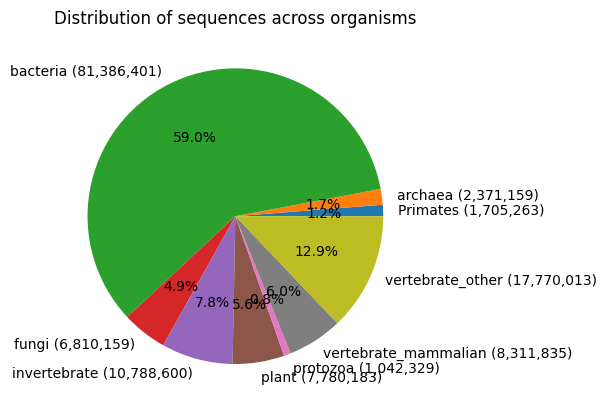

In [15]:
labels = [f"{cls} ({cnt:,})" for cls, cnt in zip(counts_df["class"], counts_df["count"])]

# Create the pie chart
plt.pie(counts_df["count"], labels=labels, autopct="%1.1f%%")
plt.title("Distribution of sequences across organisms")
# plt.savefig('{OUTPUT_DIR}/sequence_distribution.png',dpi=300)
plt.show()

In [16]:
meta["new_group"] = [
    ref_classes[t] if ref_classes[t] == "Primates" else v
    for a, t, v in meta[["#assembly_accession", "taxid", "group"]].values
]

(-1.0999995586762301,
 1.0999971806621396,
 -1.0999995569608638,
 1.0999999676675032)

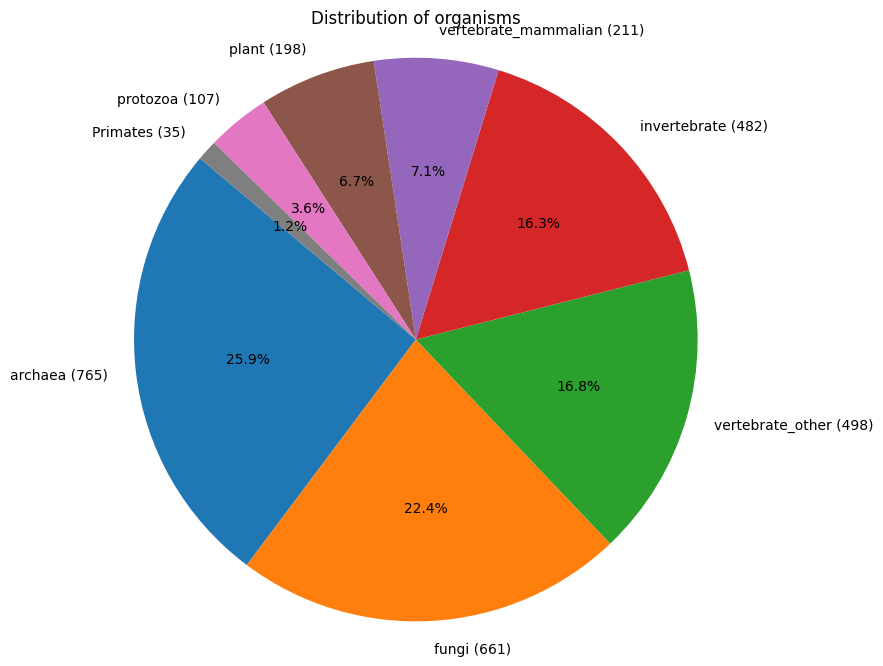

In [17]:
org_counts = meta["new_group"].value_counts().reset_index().values
labels = [f"{label} ({count})" for label, count in org_counts if label != "bacteria"]  # Add counts to labels
sizes = list([x[1] for x in org_counts[1:] if x[0] != "bacteria"])  # Counts as sizes for the pie chart

# Create the pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of organisms")
plt.axis("equal")
# plt.savefig('ncbi_refseq_reference/organism_distribution.png', dpi=300)

(-1.09999999617933, 1.0999999348653353, -1.09999982911095, 1.099999941725001)

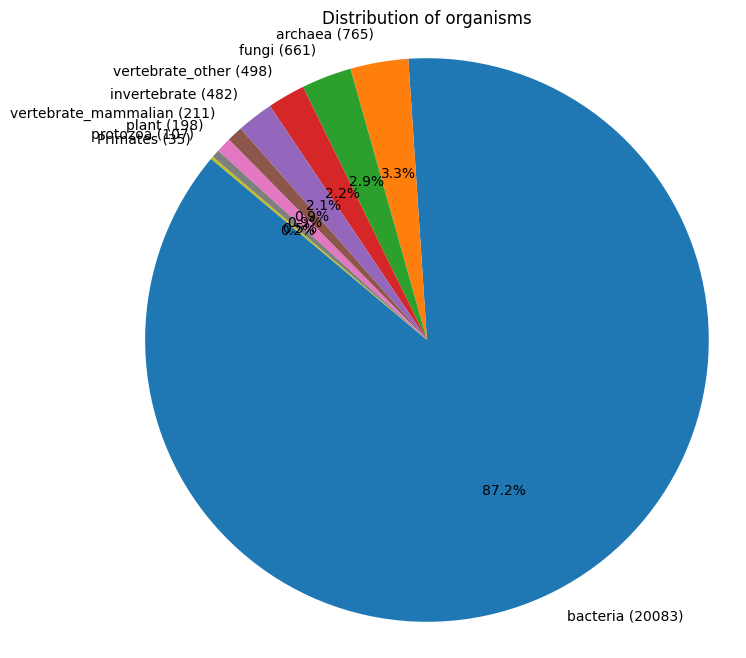

In [19]:
org_counts = meta["new_group"].value_counts().reset_index().values
labels = [f"{label} ({count})" for label, count in org_counts[:]]  # Add counts to labels
sizes = list([x[1] for x in org_counts[:]])  # Counts as sizes for the pie chart

# Create the pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of organisms")
plt.axis("equal")
# plt.savefig('ncbi_refseq_reference/organism_distribution_with_bac.png', dpi=300)